<code> 
<strong><font size="+3">COLLECTING & COMPARING ALL BLOB-LIKE EVENTS</font></strong>
In this Jupyter notebook, we collect all blob-like events from all ensemble members.
</code>

<code> Import packages </code>

In [1]:
import xarray as xr; import numpy as np; import pandas as pd
import netCDF4 as nc; import scipy
import matplotlib.pyplot as plt
import cmocean
from sklearn import preprocessing # will use MinMaxScaler from sklearn

<code> Area of interest </code>

In [2]:
# latitude and longitude range for the North Pacific Ocean
lon_lim_less = 0.; lon_lim_great = 67.5 # x
lat_lim_less = 20.; lat_lim_great = 60. # y

# rescale
x_list = np.array([-180, lon_lim_less, lon_lim_great, 180]).reshape(-1,1)
x_scaler = preprocessing.MinMaxScaler(feature_range=(0, 287))
x_normalizedlist=x_scaler.fit_transform(x_list)

y_list = np.array([-90, lat_lim_less, lat_lim_great, 90]).reshape(-1,1)
y_scaler = preprocessing.MinMaxScaler(feature_range=(0, 191))
y_normalizedlist=y_scaler.fit_transform(y_list)

In [3]:
f_row = int(np.round(y_normalizedlist[1].item()))
l_row = int(np.round(y_normalizedlist[2].item()))

f_col = int(np.round(x_normalizedlist[1].item()))
l_col = int(np.round(x_normalizedlist[2].item()))

In [4]:
print(f_row)
print(l_row)

print(f_col)
print(l_col)

117
159
144
197


In [5]:
f_row_small = int(np.round(y_normalizedlist[1].item()))
l_row_small = int(np.round(y_normalizedlist[2].item()))

f_col_small = (x_normalizedlist[1].item()+((x_normalizedlist[2].item()-x_normalizedlist[1].item())/2))
l_col_small = int(np.round(x_normalizedlist[2].item()))

In [6]:
print(f_row_small)
print(l_row_small)

print(f_col_small)
print(l_col_small)

117
159
170.40625
197


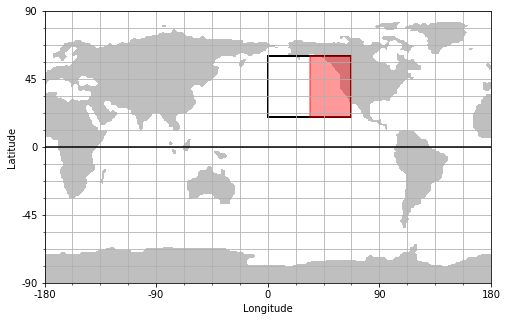

In [7]:
from matplotlib import patches # for the purpose of plotting

NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='k', facecolor='none',alpha=1.) 
NPO_smaller_patch_rotated = patches.Rectangle((x_normalizedlist[1].item()+((x_normalizedlist[2].item()-x_normalizedlist[1].item())/2), y_normalizedlist[1].item()), (x_normalizedlist[2].item()-x_normalizedlist[1].item())/2, y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='red', facecolor='red',alpha=.4) 

# landmask with relabeled axes
land_mask = np.load('SST_land.npy')
land_mask[land_mask > 0] = np.nan

fig, ax = plt.subplots(figsize=(8,5))
ax.contourf(land_mask, cmap='binary')
ax.minorticks_on()
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')
ax.add_patch(NPO_patch)
ax.add_patch(NPO_smaller_patch_rotated)

plt.show()

<code> Collecting all blob-like events </code>

In [8]:
%%time
# Note: This takes about 33 minutes to run 10 ensemble members. For 100 ensemble members, it will take around 5.5 hours.

kept_heatwaves_all = []
for ens_memb in range(99,100):
    filename = '/glade/work/cassiacai/member{}_events.nc'.format(ens_memb)
    member_ = xr.open_dataset(filename)
    ending_val = len(np.unique(member_.labels))
    
    # kept_heatwaves = []
    for i in range(1,ending_val):
        mhw_id = i
        mhw_event_rel = member_.where(member_.labels==mhw_id, drop=False)
        x = mhw_event_rel.SSTA[:,:,:]
        no_nans_x = np.nan_to_num(x)
        no_nans_x[no_nans_x != 0] = 1
        
        sum_of_one = no_nans_x.sum(axis=(0))
        event_len = np.nanmax(sum_of_one)
        
        if np.sum(sum_of_one[f_row:l_row,f_col:l_col]) > 0 and np.nanmax(sum_of_one) > 2: 
            array_of_interest = np.copy(sum_of_one[f_row:l_row,f_col:l_col])
            array_of_interest[array_of_interest != 0] = 1
            if np.nansum(array_of_interest) / (42*53*0.01) >= 25: 
                mhw_event_sel = member_.where(member_.labels==i, drop=False)
                # kept_heatwaves.append(mhw_event_sel)
                kept_heatwaves_all.append(mhw_event_sel)

CPU times: user 1min 55s, sys: 1min 29s, total: 3min 25s
Wall time: 3min 30s


In [9]:
concated_kept_heatwaves_xarray = xr.concat(kept_heatwaves_all, "heatwave_label")

In [10]:
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member0_9_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member10_19_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member20_29_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member30_39_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member40_49_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member50_59_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member60_69_bloblike_events_new_stuff.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member70_79_bloblike_events_new_stuff_.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member80_89_bloblike_events_new_stuff_.nc')
concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member90_99_bloblike_events_new_stuff_.nc')

# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member10_19_bloblike_events.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member20_29_bloblike_events.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member30_39_bloblike_events.nc')
# concated_kept_heatwaves_xarray.to_netcdf('/glade/work/cassiacai/member40_49_bloblike_events.nc')

<code> Comparing all collected blob-like events </code>

In [34]:
# filename = '/glade/work/cassiacai/member0_9_bloblike_events_new_stuff.nc' # 118 heatwave events
# filename = '/glade/work/cassiacai/member10_19_bloblike_events_new_stuff.nc' # 99 heatwave events
# filename = '/glade/work/cassiacai/member20_29_bloblike_events_new_stuff.nc' # 121 heatwave events
# filename = '/glade/work/cassiacai/member30_39_bloblike_events_new_stuff.nc' # 116 heatwave events
# filename = '/glade/work/cassiacai/member40_49_bloblike_events_new_stuff.nc' # 116 heatwave events
# filename = '/glade/work/cassiacai/member50_59_bloblike_events_new_stuff.nc' # 123 heatwave events
# filename = '/glade/work/cassiacai/member60_69_bloblike_events_new_stuff.nc' # 112 heatwave events
# filename = '/glade/work/cassiacai/member70_79_bloblike_events_new_stuff_.nc' # 105 heatwave events
filename = '/glade/work/cassiacai/member80_89_bloblike_events_new_stuff_.nc' # 99 heatwave events
# filename = '/glade/work/cassiacai/member90_99_bloblike_events_new_stuff_.nc' # 12 heatwave events Maybe there is something wrong here?

blob_like_file = xr.open_dataset(filename)

In [ ]:
r20i1301p1f2
r20i1281p1f2

In [35]:
blob_like_file

<xarray.Dataset>
Dimensions:    (heatwave_label: 99, time: 481, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 1975-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member_id  (heatwave_label) object ...
    quantile   float64 ...
    month      (time) int64 ...
Dimensions without coordinates: heatwave_label
Data variables:
    labels     (heatwave_label, time, lat, lon) float64 ...
    SSTA       (heatwave_label, time, lat, lon) float64 ...

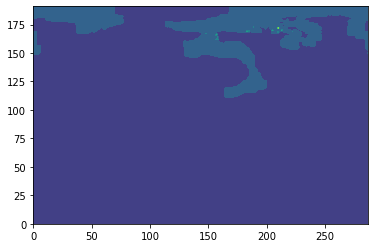

In [27]:
plt.contourf(blob_like_file.SSTA[0,:,:,:].sum(axis=(0)))

In [ ]:
cumulative_SSTA = []
area_filled_of_region_with_days = []
area_filled_of_region_wo_days = []
length_of_event = []

for i in range((np.shape(np.asarray(blob_like_file.SSTA))[0])):
    x = blob_like_file.SSTA[i,:,:,:]

    # cumulative SSTA (summing SSTAs across all days)
    cumulative_SSTA.append(x.sum(axis=(0)))

    # collecting events that fill up X percentage of our area of interest
    no_nans_x = np.nan_to_num(x)
    no_nans_x[no_nans_x != 0] = 1
    sum_of_one = no_nans_x.sum(axis=(0))
    array_of_interest = np.copy(sum_of_one[f_row:l_row,f_col:l_col])

    area_filled_of_region_with_days.append(np.nansum(array_of_interest) / (42*53*0.01))
    length_of_event.append(np.nanmax(array_of_interest))
    array_of_interest[array_of_interest != 0] = 1
    area_filled_of_region_wo_days.append(np.nansum(array_of_interest) / (42*53*0.01))

In [ ]:
print(np.nanmax(area_filled_of_region_wo_days))
print(np.nanmin(area_filled_of_region_wo_days))

In [ ]:
print(len(length_of_event))
print(np.nanmax(length_of_event))
print(np.nanmean(length_of_event))
print(np.nanmin(length_of_event))

In [ ]:
plt.hist(length_of_event,bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], rwidth=0.8)
plt.xlabel('length of event in months')
plt.ylabel('frequency')
plt.grid()
plt.xticks([2,4,6,8,10,12,14,16,18,20,22,24,26])
plt.yticks([2,4,6,8,10,12,14,16,18,20,22])
plt.show()

In [ ]:
statement = np.argwhere((np.asarray(length_of_event) >= 2) & (np.asarray(area_filled_of_region_wo_days) > 25))
print(len(statement))

In [ ]:
x = blob_like_file.SSTA[9,:,:,:]
x_summed_SSTA = x.sum(axis=(0))
no_nans_x = np.nan_to_num(x)
no_nans_x[no_nans_x != 0] = 1
sum_of_one = no_nans_x.sum(axis=(0))

In [ ]:
plt.contourf(sum_of_one)

In [ ]:
x_summed_SSTA = x.sum(axis=(0))
np.nanmax(x_summed_SSTA)
np.nanmin(x_summed_SSTA)

In [ ]:
from matplotlib import patches # for the purpose of plotting

NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='k', facecolor='none',alpha=1.) 

# landmask with relabeled axes
land_mask = np.load('SST_land.npy')
land_mask[land_mask > 0] = np.nan

fig, ax = plt.subplots(figsize=(10,5))
contourf_  = ax.contourf(sum_of_one, cmap=cmocean.cm.matter,levels=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
cbar = fig.colorbar(contourf_)
cbar.set_label('# of months', rotation=270,labelpad=15)

ax.contourf(land_mask, cmap='binary')
ax.minorticks_on()
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')
ax.add_patch(NPO_patch)
plt.show()

In [ ]:
from matplotlib import patches # for the purpose of plotting

NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='k', facecolor='none',alpha=1.) 

# landmask with relabeled axes
land_mask = np.load('SST_land.npy')
land_mask[land_mask > 0] = np.nan

fig, ax = plt.subplots(figsize=(10,5))
contourf_  = ax.contourf(x_summed_SSTA, cmap=cmocean.cm.matter,levels=[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32])
cbar = fig.colorbar(contourf_)
cbar.set_label('Cumulative SSTA', rotation=270,labelpad=15)

ax.contourf(land_mask, cmap='binary')
ax.minorticks_on()
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')
ax.add_patch(NPO_patch)
plt.show()

In [ ]:
for i in range(len(statement)):
    event_label = statement[i][0]
    print(i)
    x = blob_like_file.SSTA[event_label,:,:,:]
    x_summed_SSTA = x.sum(axis=(0))
    no_nans_x = np.nan_to_num(x)
    no_nans_x[no_nans_x != 0] = 1

    sum_of_one = no_nans_x.sum(axis=(0))
    array_of_interest = np.copy(sum_of_one[f_row:l_row,f_col:l_col])
    print(np.nansum(array_of_interest) / (42*53*0.01))
    print(np.nanmax(array_of_interest))
    array_of_interest[array_of_interest != 0] = 1
    print(np.nansum(array_of_interest) / (42*53*0.01))

    NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='red', facecolor='none',alpha=1.) 

    fig, ax = plt.subplots(figsize=(8,5))
    ax.contourf(sum_of_one)
    ax.contourf(land_mask, cmap='binary')
    ax.minorticks_on()
    ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
    ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
    ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
    ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
    ax.grid(which='both')
    ax.add_patch(NPO_patch)
    plt.show()

#     fig, ax = plt.subplots(figsize=(8,5))
#     ax.contourf(x_summed_SSTA, cmap='Reds')
#     ax.contourf(land_mask, cmap='binary')
#     ax.minorticks_on()
#     ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
#     ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
#     ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
#     ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
#     ax.grid(which='both')
#     plt.show()

In [ ]:
# for i in range(5):
#     x = blob_like_file.SSTA[i,:,:,:]
#     x_summed_SSTA = x.sum(axis=(0))
#     no_nans_x = np.nan_to_num(x)
#     no_nans_x[no_nans_x != 0] = 1

#     sum_of_one = no_nans_x.sum(axis=(0))
#     array_of_interest = np.copy(sum_of_one[f_row:l_row,f_col:l_col])
#     print(np.nansum(array_of_interest) / (42*53*0.01))
#     print(np.nanmax(array_of_interest))
#     array_of_interest[array_of_interest != 0] = 1
#     print(np.nansum(array_of_interest) / (42*53*0.01))

#     NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='k', facecolor='none',alpha=1.) 

#     fig, ax = plt.subplots(figsize=(8,5))
#     ax.contourf(sum_of_one)
#     ax.contourf(land_mask, cmap='binary')
#     ax.minorticks_on()
#     ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
#     ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
#     ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
#     ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
#     ax.grid(which='both')
#     ax.add_patch(NPO_patch)
#     plt.show()

#     fig, ax = plt.subplots(figsize=(8,5))
#     ax.contourf(x_summed_SSTA, cmap='Reds')
#     ax.contourf(land_mask, cmap='binary')
#     ax.minorticks_on()
#     ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
#     ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
#     ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
#     ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
#     ax.grid(which='both')
#     plt.show()

In [ ]:
if np.sum(sum_of_one[f_row:l_row,f_col:l_col]) > 0 and np.nanmax(sum_of_one) > 2: 
            array_of_interest = np.copy(sum_of_one[f_row:l_row,f_col:l_col])
            array_of_interest[array_of_interest != 0] = 1
            if np.nansum(array_of_interest) / (42*53*0.01) >= 25: 

In [ ]:
event_lengths = []
for i in range(118):
    x = blob_like_file.SSTA[i,:,:,:]
    no_nans_x = np.nan_to_num(x)
    no_nans_x[no_nans_x != 0] = 1

    sum_of_one = no_nans_x.sum(axis=(0))
    print(np.shape(sum_of_one))
    event_lengths.append(np.nanmax(sum_of_one))

In [ ]:
print(np.argwhere(np.asarray(event_lengths)>20))

In [ ]:
from matplotlib import patches # for the purpose of plotting

# NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=2, edgecolor='k', facecolor='none',alpha=1.) 

# landmask with relabeled axes
land_mask = np.load('SST_land.npy')
land_mask[land_mask > 0] = np.nan

fig, ax = plt.subplots(figsize=(8,5))
ax.contourf(blob_like_file.SSTA[112,:,:,:].sum(axis=(0)))
ax.contourf(land_mask, cmap='binary')
ax.minorticks_on()
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')
# ax.add_patch(NPO_patch)
plt.show()

In [ ]:
fig, axs = plt.subplots(3,5, figsize=(22, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.1)
axs = axs.ravel()

for i in range(len(kept_indices)):
    NPO_patch = patches.Rectangle((x_normalizedlist[1].item(), y_normalizedlist[1].item()), x_normalizedlist[2].item()-x_normalizedlist[1].item(), y_normalizedlist[2].item()-y_normalizedlist[1].item(), linewidth=1, edgecolor='white', facecolor='none',alpha=1) 

    axs[i].contourf(full__analysis_arrays[kept_indices[i]])
    axs[i].contourf(land_mask,cmap='binary_r',vmin=0)
    axs[i].minorticks_on()
    axs[i].axhline(y=95.5, c='white', linestyle='-') # this is the equator line
    axs[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axs[i].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    axs[i].add_patch(NPO_patch)

In [ ]:
plt.hist(event_lengths,bins=[0,2,4,6,8,10,12,14,16,18,20,22,24,26])
plt.show()